In [67]:
# Connecting to MySQL database

import mysql.connector as mcdb
mysqldb = mcdb.connect(host='localhost', user='root', passwd='', db='PentaCloud') #Insert personal sql passwd
mycursor = mysqldb.cursor()

In [68]:
# Adding a new organisation to the database

def addOrganisation(name):
    try:
        mycursor.execute(f"SELECT * FROM Organisation WHERE Name = '{name}'")
        if len(mycursor.fetchall()) > 0:
            print(name + ' is already registered.')
        else:
            mycursor.execute(f"INSERT INTO Organisation (Name, Alert, Source) VALUES ('{name}', 'Normal', 'Source')")
            mysqldb.commit()
            print(name + ' has been successfully registered!')
    except:
        mysqldb.rollback()
        print('Error.')

In [69]:
# Adding a new supply link to the database, along with the price of the product delivered

def addLink(fromOrg, toOrg, price):
    try:
        mycursor.execute(f"SELECT * FROM SupplyLink WHERE FromOrg = '{fromOrg}' AND ToOrg = '{toOrg}'")
        if len(mycursor.fetchall()) > 0:
            print('Supply link from ' + fromOrg + ' to ' + toOrg +  ' is already registered.')
        else:
            mycursor.execute(f"SELECT * FROM Organisation WHERE Name = '{fromOrg}'")
            if len(mycursor.fetchall()) == 0:
                addOrganisation(fromOrg)
            mycursor.execute(f"SELECT * FROM Organisation WHERE Name = '{toOrg}'")
            result = mycursor.fetchall()
            if len(result) == 0:
                addOrganisation(toOrg)
                mycursor.execute(f"UPDATE Organisation SET Source = 'Non-source' WHERE Name = '{toOrg}'")
                mysqldb.commit()
            elif result[0][3] == "Source":
                mycursor.execute(f"UPDATE Organisation SET Source = 'Non-source' WHERE Name = '{toOrg}'")
                mysqldb.commit()
                
            mycursor.execute(
                f"INSERT into SupplyLink (FromOrg, ToOrg, Price) VALUES ('{fromOrg}', '{toOrg}', '{price}')")
            mysqldb.commit()
            print('Supply link from ' + fromOrg + ' to ' + toOrg +  ' has been successfully recorded!')
    except:
        mysqldb.rollback()
        print('Error.')

In [70]:
# Ammend the alert status of a company when a crisis has severely impacted the companny, and ammend it back after a crisis

def changeAlert(name):
    try:
        mycursor.execute(f"SELECT * FROM Organisation WHERE Name = '{name}'")
        result = mycursor.fetchall()
        if len(result) > 0:
            if result[0][2] == "Normal":
                mycursor.execute(f"UPDATE Organisation SET Alert = 'Crisis' WHERE Name = '{name}'")
                mycursor.execute(f"SELECT LinkID FROM SupplyLink WHERE fromOrg = '{name}'")
                result2 = mycursor.fetchall()[0]
                for link in result2:
                    # Supply price increase by an arbitary figure of $100 during a crisis. Actual price increment figure will be determined by extent of demand and supply changes.
                    mycursor.execute(f"UPDATE SupplyLink SET Price = Price + 100 WHERE LinkID = '{link}'")
                print(name + '\'s alert status successfully ammended to Crisis!')
            elif result[0][2] == "Crisis":
                mycursor.execute(f"UPDATE Organisation SET Alert = 'Normal' WHERE Name = '{name}'")
                mycursor.execute(f"SELECT LinkID FROM SupplyLink WHERE fromOrg = '{name}'")
                result2 = mycursor.fetchall()[0]
                for link in result2:
                    # Supply price reduces back by the arbitary figure of $100.
                    mycursor.execute(f"UPDATE SupplyLink SET Price = Price - 100 WHERE LinkID = '{link}'")
                print(name + '\'s alert status successfully ammended to Normal!')
        else:
            print(name + ' is not registered.')
        mysqldb.commit()
    except:
        mysqldb.rollback()
        print('Error.')

In [71]:
# Determines the best supplier for the company

def findBestSupplier(company):
    G = nx.DiGraph()
    
    mycursor.execute(f"SELECT * FROM Organisation WHERE Name = '{company}'")
    if len(mycursor.fetchall()) == 0:
        return company + " is not registered."

    mycursor.execute(f"SELECT Name, Alert FROM Organisation")
    result = mycursor.fetchall()
    G.add_nodes_from(list(map(lambda x: x[0], result)))

    mycursor.execute(f"SELECT FromOrg, ToOrg, Price FROM SupplyLink")
    G.add_weighted_edges_from(mycursor.fetchall())
    
    mycursor.execute(f"SELECT Name, Source FROM Organisation")
    sourceOrgs = set(map(lambda y: y[0], filter(lambda x: x[1] == "Source", mycursor.fetchall())))

    p = nx.multi_source_dijkstra(G, sourceOrgs, company)
    if len(p[1]) == 1:
        return "There are no available suppliers registered."
    return p[1][-2]

In [72]:
# Displays all possible suppliers, arranged by increasing price

def viewMySuppliers(company):
    mycursor.execute(f"SELECT FromOrg, Price FROM SupplyLink WHERE ToOrg = '{company}'")
    result = list(mycursor.fetchall())
    result.sort(key = lambda x: x[1])
    return list(map(lambda y: y[0], result))

In [73]:
import networkx as nx

# Displays graph for visualisation (for internal use; not shown to organisations)
def depictGraph():
    G = nx.DiGraph()

    mycursor.execute(f"SELECT Name, Alert FROM Organisation")
    result = mycursor.fetchall()
    G.add_nodes_from(list(map(lambda x: x[0], result)))

    color_map = list(map(lambda x: "green" if x[1] == "Normal" else "red", result))

    mycursor.execute(f"SELECT FromOrg, ToOrg, Price FROM SupplyLink")
    G.add_weighted_edges_from(mycursor.fetchall())

    nx.draw_networkx(G, node_color=color_map, with_labels = True)

Amaze Resources has been successfully registered!
Best Supplies has been successfully registered!
Cando Materials has been successfully registered!
Delight Items has been successfully registered!
Eager Consumables has been successfully registered!
Supply link from Amaze Resources to Best Supplies has been successfully recorded!
Supply link from Amaze Resources to Cando Materials has been successfully recorded!
Supply link from Best Supplies to Delight Items has been successfully recorded!
Supply link from Cando Materials to Delight Items has been successfully recorded!
Supply link from Cando Materials to Eager Consumables has been successfully recorded!
Cando Materials
['Cando Materials', 'Best Supplies']
Cando Materials's alert status successfully ammended to Crisis!
Best Supplies
['Best Supplies', 'Cando Materials']


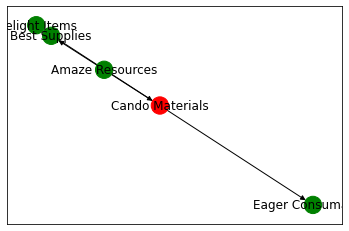

In [74]:
# Test cases

addOrganisation("Amaze Resources")
addOrganisation("Best Supplies")
addOrganisation("Cando Materials")
addOrganisation("Delight Items")
addOrganisation("Eager Consumables")

addLink("Amaze Resources", "Best Supplies", 170)
addLink("Amaze Resources", "Cando Materials", 150)
addLink("Best Supplies", "Delight Items", 120)
addLink("Cando Materials", "Delight Items", 100)
addLink("Cando Materials", "Eager Consumables", 130)

print(findBestSupplier('Delight Items'))
print(viewMySuppliers('Delight Items'))

changeAlert("Cando Materials")

print(findBestSupplier('Delight Items'))
print(viewMySuppliers('Delight Items'))
depictGraph()